# Satellite Derived Bathymetry using the Stumpf Log-Regression Method for the Puerto Rico Area of Interest

Author: Gregor Beyerle

Date: 2022-06-19

## Overview

This notebook contains the steps taken to perform SDB estimations for the L2A and Acolite data products for this AOI. This includes:

- Loading the prepared data
- Setting up training and test data splits
- Calibrating the model
- Evaluating the model

Stumpf Log-Regression is usually used on bottom of the atmosphere reflectance values, so I omit the same process for the L1C product.

In [1]:
import os
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.ml_tools import TrainTestSplitTask

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

import dalex as dx

This notebook uses functionality of both the `eolearn_extras` module as well as the `sdb_utils` module. It is important to add the relative location of the repository's root directory to the `sys.path` and import `eolearn_extras` before `sdb_utils` as some functions in this module reference `eolearn_extras`.

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.stumpf import get_stumpf_log_ratio
from sdb_utils.ml_utils import (
    create_sdb_estimation,
    get_X_y_for_split,
    SplitType,
)

The data for this project can - depending on whether you work with the complete dataset or only the preprocessed data - be roughly 13 GB on disk. This makes it necessary to distribute data individually from the repository and therefore the location of the data root directory might differ from setup to setup. This repository uses a `.env` file to configure the individual data root directory location. You need to add the `.env` file to your `notebooks` directory and add a line containing the needed information as a line following the pattern `data_root=<path-to-your-data-root>` in order for this notebook to work correctly.

In [3]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

We already prepared the needed data for this AOI in previous notebooks. The first step of the workflow for preparing the train-test-split is to load it from disk.

In [4]:
puerto_rico_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'puerto_rico_sentinel_merged')
)
load_puerto_rico_eop = LoadTask(puerto_rico_eop_path)

The eo-learn framework includes a `TrainTestSplitTask` which can be used to create a mask with an arbitrary amount of numerical class (e.g. train, validation and test) labels. For this AOI I decided to use 5% of all possible pixels for training. I did not want to use more samples because with the AOI not offering a very high degree of variance and the spatial resolution being relatively high, the danger of overfitting appears to be especially pressing. Also, even if in reality a field survey is unlikely to perform a uniform sampling over the whole AOI, I would like to perform an analysis that has some use for people that only have the possibility to survey a limited amount of point tracks when collecting their own calibration data.

In [5]:
data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

The `TrainTestSplitTask` does not itself take an argument for masking out "uninteresting" pixels. Also, it does produce only one mask for all classes, which is - at times - cumbersome to use. I use the `AddValidTrainTestMasks` to combine the bathymetry data mask and the pixel locations of each split to their own masks.

In [6]:
valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

The workflow for performing this preparation is comparatively simple as seen in the dependency graph below.

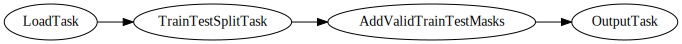

In [7]:
tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_puerto_rico_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task,
)
read_merge_wf = EOWorkflow(nodes)

read_merge_wf.dependency_graph()

Without configuring a random seed to the `TrainTestSplitTask` the pixels in each split would differ with each execution. While this should not impact the analysis it would impair others to repeat the analysis and come to the exact same results. The `seed` argument has to be configured at execution time. To do this in the context of a workflow rather than a simple task execution we can find the `EONode` reference in the list of nodes which was implicitly created for us when we executed the `linearly_connected_tasks` function.

After executing the workflow we can see that we now have the required masks as well as some additional information in the `meta_info` that helps to gain an intuition for the magnitude of each supported split.

In [8]:
train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 319, 544, 13), dtype=float32)
    L2A_data: numpy.ndarray(shape=(1, 319, 544, 12), dtype=float32)
    L2R_data: numpy.ndarray(shape=(1, 319, 544, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(319, 544, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(319, 544, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(319, 544, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(319, 544, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(319, 544, 1), dtype=int64)
  }
  meta_info={
    test_count: 164983
    test_perc: 0.9507133966439241
    train_count: 8553
    train_perc: 0.04928660335607597
    validation_count: 0
    validation_perc: 0.0
  }
  bbox=BBox(((686070.726989808, 2007089.913413469), (691510.726989808, 2010279.913413469)), crs=CRS('32619'))
  timestamp=[datetime.datetime(2021, 5, 2, 15, 7, 19), datetime.datetime(2021, 5, 2, 15, 7, 

## Performing SDB on the Basis of L2A Data

To calibrate the model we have to retrieve the "label values" (true bathymetry values) first.

In [9]:
_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

In a common regression scenario I would take some or all band values for a pixel location as the explanatory variables. If we look at the formula for the Stumpf method it becomes clearer why we would take another approach.

$$
Z = m_1\frac{ln(nR_w(\lambda_i))}{ln(nR_w(\lambda_j))} - m_0
$$

In other terms we can interpret $Z$ as the estimated bathymetry value (or the $\hat{y}$ of the regression), $n$ as a given constant that is used to force a positive value for the logarithm, the function $R_w$ as the reflectance value for a given $\lambda$, $m_0$ as the calibrated regression intercept and $m_1$ as the calibrated regression coefficient (Stumpf et al., 2003).

If we want to to stay within this mathematical notation the data for `X_train` returned by `get_stumpf_log_ratio` could be described as

$$
X_{train} = \frac{ln(nR_w(\lambda_i))}{ln(nR_w(\lambda_j))}
$$

where $R_w(\lambda_i)$ corresponds to the blue band and $R_w(\lambda_j)$ corresponds to the green band.

In [10]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), train_mask_single_band)

With the data in place the rest of the modelling process boils down to just fitting a linear model. We have full freedom regarding how we want to fit the linear model to calibrate $m_0$ and $m_1$. If we want to have a full statistical evaluation of the linear model we can use the ordinary least squares (OLS) method from statsmodels (Seabold and Perktold, 2010). We only have to keep in mind that statsmodels (in contrast to scikit-learn) does not automatically model constants so we have to adapt the training set in preparation for the model construction.

The summary of the model shows us a very detailed picture of the most important evaluation metrics for the linear regression.

In [11]:
X_train_intercept = sm.add_constant(X_train)
reg_mod = sm.OLS(y_train, X_train_intercept)
reg = reg_mod.fit()
reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.712     
Dependent Variable: y                AIC:                29195.5919
Date:               2022-06-19 21:53 BIC:                29209.7000
No. Observations:   8553             Log-Likelihood:     -14596.   
Df Model:           1                F-statistic:        2.116e+04 
Df Residuals:       8551             Prob (F-statistic): 0.00      
R-squared:          0.712            Scale:              1.7778    
--------------------------------------------------------------------
          Coef.    Std.Err.      t      P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
const    121.9429    0.8892   137.1303  0.0000   120.1997   123.6860
x1      -126.9472    0.8727  -145.4599  0.0000  -128.6579  -125.2364
-------------------------------------------------------------------
Omnibus:             1159.133      Durbin-Watson:         1.269    
Prob(Omnibus):       0.000         Jarque-Bera (JB):      15300.511
Skew:                -0.084        Prob(JB):              0.000    
Kurtosis:            9.550         Condition No.:         123      
===================================================================

"""

As we are estimating pixel values for a bathymetry map we can generate estimates for the whole map to visualize the model output. In the below cell we retrieve all valid explanatory data to produce a completely estimated map. While showing a far "grainier" picture than the ground truth image we see a picture that successfully captured the general features of the bathymetric profile of the AOI.

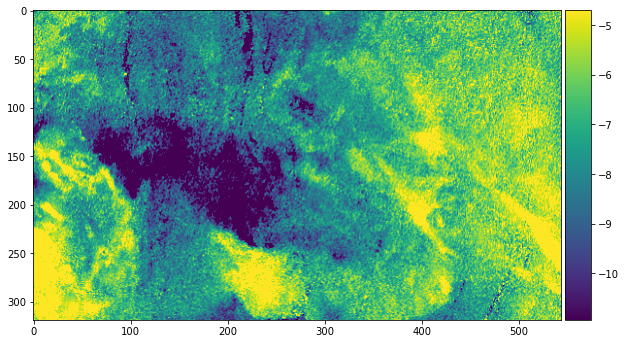

In [12]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), mask_complete_single_band)
X_all_intercept = sm.add_constant(X_all)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all_intercept)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

When we visualize the estimation errors using a similar visualization we can see that the model underestimates the depth in particularly deep regions while overestimating some finer and shallower features.

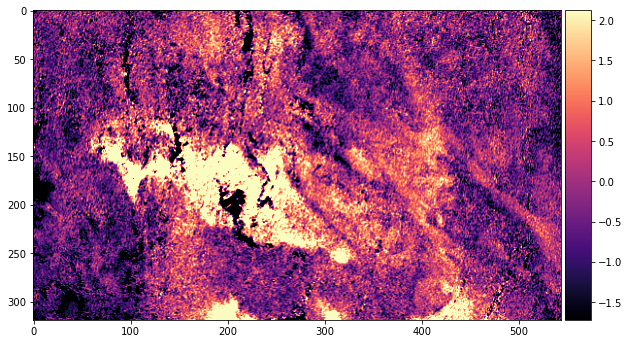

In [13]:
l2a_sdb_errors = l2a_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

We can perform simple diagnostics for the linear regression by calculating the residuals and looking at their distribution. While there are long tails to both sides, almost all residuals span a range of -5 to 5 meters.

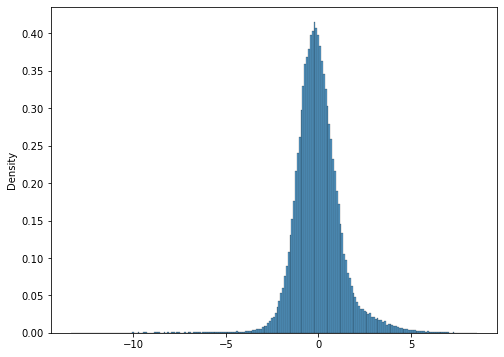

In [14]:
_, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

Plotting the estimated values against the true bathymetry values shows that there is clearly visible linear correlation which gets decidedly weaker for deeper regions in the AOI. This behavior corresponds with what is generally described in the literature (Stumpf et al., 2003).

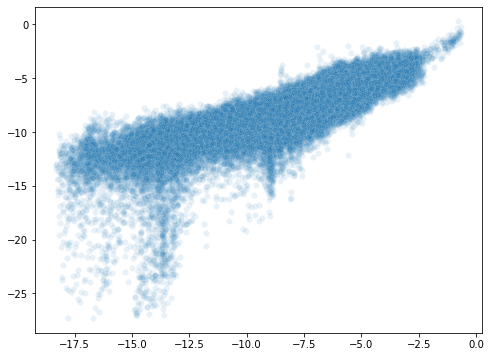

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=l2a_sdb_estimation_values, alpha=0.1, ax=ax)
plt.show()

Another diagnostic tool for inspecting the validity of the linear regression would be a `QQPlot`. The local behavior for lower depth value residuals shows a far wider spread than would be assumed in a normally distributed data set. We see a similar but far less extreme divergence from normality for shallower depth estimations.

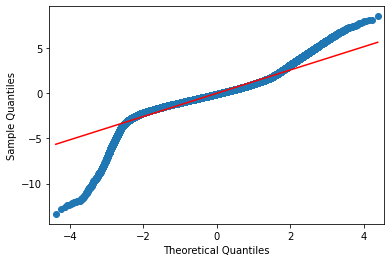

In [16]:
sm.qqplot(l2a_sdb_residuals, line='s')
plt.show()

While it wouldn't be strictly necessary for this model as the Stumpf method is well explored and calibration is performed via a simple linear regression, I am using a [Dalex](https://dalex.drwhy.ai/python/api/index.html#overview) explainer (Baniecki et al., 2021) to extract the most common performance statistics for regression tasks. From that we can extract that for the given AOI based on the L2A data the model explains around 72% of the variance with a root means squared error of 1.29 meters.

In [17]:
import warnings
# avoid showing warnings for feature names
warnings.filterwarnings('ignore')

exp_stumpf_l2a = dx.Explainer(reg, X_all_intercept, y_all, label='stumpf_tuned_l2a', verbose=False)
exp_stumpf_l2a.model_performance()

,mse,rmse,r2,mae,mad
stumpf_tuned_l2a,1.654052,1.2861,0.718902,0.911091,0.687706


## Performing SDB on the Basis of Acolite Data

After performing the analysis on the basis of the L2A dataset we can now take a look at the alternative result we can achieve using the alternative data extracted from the Acolite product. As the process remains mostly the same with the difference that we are using a different set of values for the explanatory variables I will omit the explanation of the details.

Looking at the visual representation of the bathymetry estimation it is hard to recognize a particularly striking difference from the one produced by calibrating the model based on the L2A data.

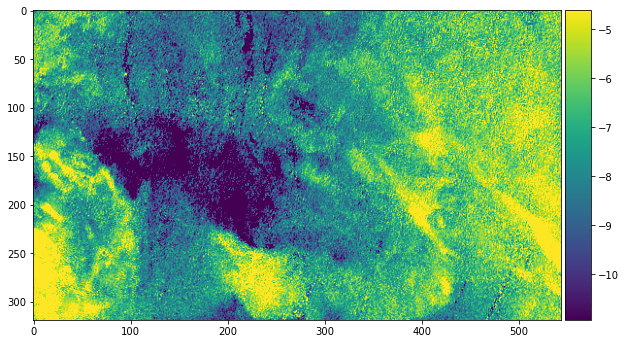

In [18]:
# extract the label data
acolite_product='L2R'
_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

# compute the `X_train` explanatory values
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), train_mask_single_band)

# fit the regression
X_train_intercept = sm.add_constant(X_train)
reg_mod = sm.OLS(y_train, X_train_intercept)
reg = reg_mod.fit()

# compute the dataset of all pixels to estimate the whole AOI
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), mask_complete_single_band)
X_all_intercept = sm.add_constant(X_all)

# estimate and plot the complete AOI
acolite_sdb_estimation_values, acolite_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all_intercept)
eolx.visualization.plot_ndarray_band(acolite_sdb_estimation_map, cmap='viridis')
plt.show()

Similarly, while it is possible to notice differences in the error map, the complete picture does not differ widely from the L2A alternative.

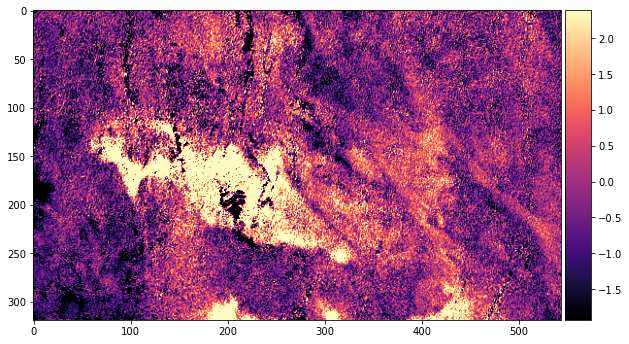

In [19]:
acolite_sdb_errors = acolite_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(acolite_sdb_errors, cmap='magma')
plt.show()

Interestingly, while the estimation map as well as the error map do not differ that much we can clearly observe changes in the model statistics.

In [20]:
reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.672     
Dependent Variable: y                AIC:                30317.8779
Date:               2022-06-19 21:53 BIC:                30331.9860
No. Observations:   8553             Log-Likelihood:     -15157.   
Df Model:           1                F-statistic:        1.751e+04 
Df Residuals:       8551             Prob (F-statistic): 0.00      
R-squared:          0.672            Scale:              2.0271    
--------------------------------------------------------------------
          Coef.    Std.Err.      t      P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
const    133.8839    1.0679   125.3730  0.0000   131.7906   135.9772
x1      -140.0708    1.0587  -132.3071  0.0000  -142.1460  -137.9955
-------------------------------------------------------------------
Omnibus:              1421.908      Durbin-Watson:         1.252   
Prob(Omnibus):        0.000         Jarque-Bera (JB):      4274.432
Skew:                 -0.868        Prob(JB):              0.000   
Kurtosis:             5.997         Condition No.:         139     
===================================================================

"""

We also get a very insightful picture when looking at the distribution of errors which is less dense around very small errors.

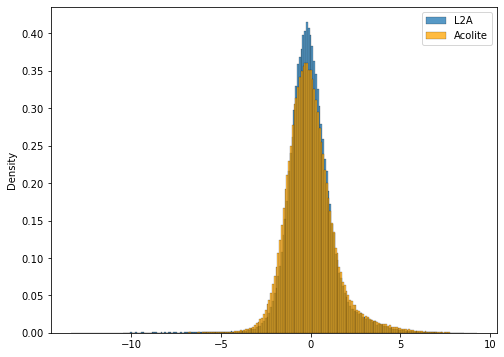

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all

sns.histplot(l2a_sdb_residuals, binwidth=0.1, label='L2A', stat='density', ax=ax)
sns.histplot(acolite_sdb_residuals, binwidth=0.1, label='Acolite', stat='density', color='orange', ax=ax)

plt.legend()
plt.show()

Looking at the scatterplot of the estimated bathymetry values against the true bathymetry values for the Acolite based model and contrasting it with its L2A counterpart I would assume that the accumulative error might be hire while the presence of extreme errors - especially for deeper water - appears to have decreased.

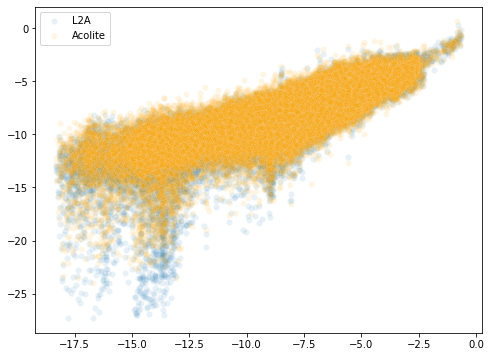

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x=y_all, y=l2a_sdb_estimation_values, label='L2A', alpha=0.1, ax=ax)
sns.scatterplot(x=y_all, y=acolite_sdb_estimation_values, label='Acolite', color='orange', alpha=0.1, ax=ax)

plt.legend()
plt.show()

Looking at the QQPlot this assumption appears even more likely.

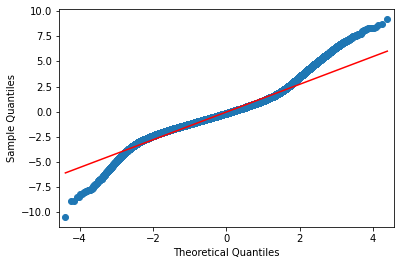

In [23]:
sm.qqplot(acolite_sdb_residuals, line='s')
plt.show()

Looking at the raw metrics we see a generally worse performance profile. While this is true, it is still interesting to consider if there are use cases where the different error profile offers a benefit that warrants the worse performance as the non-trivial handling of the Accolite processor.

In [24]:
exp_stumpf_acolite = dx.Explainer(reg, X_all_intercept, y_all, label='stumpf_tuned_acolite', verbose=False)
exp_stumpf_acolite.model_performance()

,mse,rmse,r2,mae,mad
stumpf_tuned_acolite,1.904926,1.380191,0.676267,1.012829,0.780019
